In [1]:
import os

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [16]:
from skimage.measure import regionprops, regionprops_table
from skimage.io import imread
from skimage.segmentation import find_boundaries, clear_border
from skimage.morphology import binary_erosion, binary_opening, binary_dilation
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from skimage.util import pad

In [4]:
import re
from glob import glob

In [5]:
from shapely.geometry import Point, Polygon

In [6]:
from matplotlib.path import Path

In [7]:
from scipy.spatial.distance import cdist

Import the file lists.

In [8]:
stardist_label_files = sorted(glob('/nas_storage/andreas.ettinger/project_agv/cellprofiler/input/*Ch4*'))

In [9]:
def get_measurements(binary_image, intensity_slice):
    img_area = binary_image.sum()
    img_sum = intensity_slice[binary_image == True].sum()
    img_sd = intensity_slice[binary_image == True].std()
    img_mean = intensity_slice[binary_image == True].mean()
    img_max = intensity_slice[binary_image == True].max()
    img_min = intensity_slice[binary_image == True].min()
    img_median = np.median(intensity_slice[binary_image == True].ravel())
    return([img_area, img_sum, img_sd, img_mean, img_max, img_min, img_median])  

## Outline ##
1. We loop through the images of labeled nuclei (stardist_labels).
2. We find the corresponding other files.
3. We find Nuclei and Cell objects with scikit-image 'regionprops'.
4. We filter Objects, Nuclei > 500, Cells < 15000.
5. We find matching Nuclei / Cell pairs, using the 'shapely' library
  - first, we make an array with all nuclei and cell centroids
  - then, we calculate the distance map (fast)
  - we find candidate matches by distance < 100
  - we loop through the indices of those candidates
  - we test if the nuclei centroid is within the cell area
  - we record matching indices of nuclei and cells
6. We loop through all matches.
7. We get the regionprops object by match index.
8. For nuclei and cells, we use the regionprops slice to only measure the intensities in the area of the cell. For membrane and cytoplasm, we use the whole image.
9. We use the binary area to find nuclei, cells, membrane and cytoplasm.
10. We save the measurements to csv file.

In [10]:
images_input_dir = '/nas_storage/andreas.ettinger/project_agv/cellprofiler/input/'
cell_labels_dir = '/nas_storage/andreas.ettinger/project_agv/race/output/item_0019_NScaleMorphologicalWatershedFilter/'

In [11]:
measurement_headers = [ ab + '_' + compartment + '_ '+ measurement
                       for ab in ['BZLF1', 'GP350'] 
                       for compartment in ['NUCLEAR', 'CELL', 'MEMBRANE', 'CYTOPLASM']
                       for measurement in ['AREA', 'SUM', 'SD', 'MEAN', 'MAX', 'MIN', 'MEDIAN']]

In [12]:
measurement_headers = ['EXPERIMENT', 'TIMEPOINT', 'TREATMENT', 'IMAGE', 'NUCLEAR_LABEL', 'CELL_LABEL'] + measurement_headers

In [245]:
i = 0

In [14]:
from joblib import Parallel, delayed

In [15]:
palette = [[141,211,199],
[255,255,179],
[190,186,218],
[251,128,114],
[128,177,211],
[253,180,98],
[179,222,105],
[252,205,229],
[217,217,217],
[188,128,189],
[204,235,197],
[255,237,111]]

In [43]:
def measure_image(stardist_label_file):
    image_data = pd.DataFrame(columns = measurement_headers)

    # get the base name
    basename = re.search('(.+)_Ch4.tif',os.path.basename(stardist_label_file))[1]
    
    # determine experimental metadata from file name
    exp_params_from_filename = re.search('([0-9]{6})_([0-9]{2}h)_([0-9]{1,}nmol)_([0-9]+)', basename)
    exp_params_list = [ exp_params_from_filename[1], exp_params_from_filename[2], exp_params_from_filename[3], exp_params_from_filename[4] ]
    
    # only continue if file has not been analysed yet
    if not os.path.exists(os.path.join('/nas_storage/andreas.ettinger/project_agv/measurements/',basename+'.csv')):
        # only continue if a matching cell segmentation image exists
        if os.path.exists(os.path.join(cell_labels_dir, basename+'_Ch2_NScaleMorphologicalWatershedFilter_Out1.tif')):

            # read in segmented images
            stardist_label_image = imread(stardist_label_file)
            stardist_label_image = clear_border(stardist_label_image)
            cell_label_image = imread(os.path.join(cell_labels_dir, basename+'_Ch2_NScaleMorphologicalWatershedFilter_Out1.tif'))

            # intensity images to be analyzed
            nuclei_image = imread(os.path.join(images_input_dir, basename+'_Ch0.tiff'))
            bzlf1_image = imread(os.path.join(images_input_dir, basename+'_Ch1.tiff'))
            membrane_image = imread(os.path.join(images_input_dir, basename+'_Ch2.tiff'))
            gp350_image = imread(os.path.join(images_input_dir, basename+'_Ch3.tiff'))

            # find nuclei and cell objects
            stardist_objects = regionprops(stardist_label_image)
            cell_objects = regionprops(cell_label_image)

            # filter objects by size
            stardist_objects = [ sd_item for sd_item in stardist_objects if sd_item.area > 500 ]
            cell_objects = [ cell_item for cell_item in cell_objects if cell_item.area < 15000 and len(cell_item.coords) > 5]

            # make list of Points and Polygons for testing if nuclei are in cells
            # only use cells where the segmentation produced > 5 points
            cell_polygons = [Polygon(cell_item.coords) for cell_item in cell_objects ]
            nuclei_points = [Point(sd_item.centroid) for sd_item in stardist_objects ]

            # find all centroids of nuclei and cells
            nuclei_centroids = [ sd_item.centroid for sd_item in stardist_objects ]
            cell_centroids = [ cell_item.centroid for cell_item in cell_objects ]
            # verify that objects were found
            if len(nuclei_centroids) > 0 and len(cell_centroids) > 0:
                # generate the distance matrix
                dmap = cdist(nuclei_centroids, cell_centroids)
                # find possible matches
                candidate_matches = np.where(dmap < 100)
                # only loop through candidates
                # only if candiates are found
                if len(candidate_matches[0]) > 0:
                    matches = [ (i,j) for i, j in zip(candidate_matches[0], candidate_matches[1]) 
                               if nuclei_points[i].within(cell_polygons[j].convex_hull)]
                    # seems to work ok, much faster

                    # for control figure
                    fig = plt.figure(figsize=(20,20))
                    ax = fig.add_subplot(111)
                    # merge nuclei and membrane intensity images
                    merged = rescale_intensity(np.add(membrane_image, nuclei_image), (0,90), (0,255))
                    # pad in case text get to lie outside
                    merged = pad(merged, pad_width=20, mode='constant')
                    # convert to rgb
                    merged = gray2rgb(merged)
                    k=0
                    # loop through matched nuclei / cells
                    for match in matches:
                        ## for nuclei and total cells we can use slices from regionprops
                        # get nuclei properties
                        the_nucleus = stardist_objects[match[0]]
                        nucl_slice = the_nucleus.slice
                        nucl_binary = the_nucleus.filled_image
                        nucl_label = the_nucleus.label
                        nucl_center = the_nucleus.centroid

                        # get cell properties
                        the_cell = cell_objects[match[1]]
                        cell_slice = the_cell.slice
                        cell_binary = the_cell.filled_image
                        cell_label = the_cell.label
                        cell_center = the_cell.centroid

                        ## use total images not slices next
                        ## membranes may lay slightly outside of slices
                        ## binary xor not possible from slices of different sizes

                        # get cytoplasm properties
                        cyto_binary = np.logical_xor(binary_dilation(cell_label_image == cell_label),(stardist_label_image == nucl_label))

                        # get membrane properties
                        membrane_binary = binary_dilation(find_boundaries(cell_label_image == cell_label, mode='thick'))

                        # measure
                        bzlf1_nuclear = get_measurements(nucl_binary, bzlf1_image[nucl_slice])
                        bzlf1_cell = get_measurements(cell_binary, bzlf1_image[cell_slice])
                        bzlf1_membrane = get_measurements(membrane_binary, bzlf1_image)
                        bzlf1_cyto = get_measurements(cyto_binary, bzlf1_image)
                        gp350_nuclear = get_measurements(nucl_binary, gp350_image[nucl_slice])
                        gp350_cell = get_measurements(cell_binary, gp350_image[cell_slice])
                        gp350_membrane = get_measurements(membrane_binary, gp350_image)
                        gp350_cyto = get_measurements(cyto_binary, gp350_image)

                        # add measurement to data frame
                        new_measurement = pd.DataFrame([exp_params_list + [nucl_label, cell_label] + bzlf1_nuclear + bzlf1_cell + bzlf1_membrane + bzlf1_cyto + gp350_nuclear + gp350_cell + gp350_membrane + gp350_cyto], columns = measurement_headers)
                        image_data = image_data.append(new_measurement, ignore_index=True)

                        # pad membrane image to fit dimensions of control image
                        membrane_binary_padded = pad(membrane_binary, pad_width=20)
                        merged[membrane_binary_padded] = palette[k]
                        # record label of cell
                        ax.text(cell_center[1], cell_center[0], str(cell_label), color = np.divide(palette[k],255))
                        # increase counter for colors
                        if k<11:
                            k = k + 1
                        else: 
                            k = 0

                    image_data.to_csv(os.path.join('/nas_storage/andreas.ettinger/project_agv/measurements/',basename+'.csv'))
                    ax.imshow(merged)
                    plt.savefig(os.path.join('/nas_storage/andreas.ettinger/project_agv/control_images/measurement_ids/', basename+'-measured-cells.png'))
                    plt.close()
            

In [28]:
measure_image(stardist_label_files[0])

In [44]:
Parallel(n_jobs=40)(delayed(measure_image)(stardist_label_file) for stardist_label_file in stardist_label_files)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [55]:
result_files = glob('/nas_storage/andreas.ettinger/project_agv/measurements/*.csv')

In [56]:
all_data = pd.DataFrame(columns = measurement_headers)

In [57]:
all_data

Empty DataFrame
Columns: [EXPERIMENT, TIMEPOINT, TREATMENT, IMAGE, NUCLEAR_LABEL, CELL_LABEL, BZLF1_NUCLEAR_ AREA, BZLF1_NUCLEAR_ SUM, BZLF1_NUCLEAR_ SD, BZLF1_NUCLEAR_ MEAN, BZLF1_NUCLEAR_ MAX, BZLF1_NUCLEAR_ MIN, BZLF1_NUCLEAR_ MEDIAN, BZLF1_CELL_ AREA, BZLF1_CELL_ SUM, BZLF1_CELL_ SD, BZLF1_CELL_ MEAN, BZLF1_CELL_ MAX, BZLF1_CELL_ MIN, BZLF1_CELL_ MEDIAN, BZLF1_MEMBRANE_ AREA, BZLF1_MEMBRANE_ SUM, BZLF1_MEMBRANE_ SD, BZLF1_MEMBRANE_ MEAN, BZLF1_MEMBRANE_ MAX, BZLF1_MEMBRANE_ MIN, BZLF1_MEMBRANE_ MEDIAN, BZLF1_CYTOPLASM_ AREA, BZLF1_CYTOPLASM_ SUM, BZLF1_CYTOPLASM_ SD, BZLF1_CYTOPLASM_ MEAN, BZLF1_CYTOPLASM_ MAX, BZLF1_CYTOPLASM_ MIN, BZLF1_CYTOPLASM_ MEDIAN, GP350_NUCLEAR_ AREA, GP350_NUCLEAR_ SUM, GP350_NUCLEAR_ SD, GP350_NUCLEAR_ MEAN, GP350_NUCLEAR_ MAX, GP350_NUCLEAR_ MIN, GP350_NUCLEAR_ MEDIAN, GP350_CELL_ AREA, GP350_CELL_ SUM, GP350_CELL_ SD, GP350_CELL_ MEAN, GP350_CELL_ MAX, GP350_CELL_ MIN, GP350_CELL_ MEDIAN, GP350_MEMBRANE_ AREA, GP350_MEMBRANE_ SUM, GP350_MEMBRANE_ SD, GP350_MEMBRANE_ MEAN, GP350_MEMBRANE_ MAX, GP350_MEMBRANE_ MIN, GP350_MEMBRANE_ MEDIAN, GP350_CYTOPLASM_ AREA, GP350_CYTOPLASM_ SUM, GP350_CYTOPLASM_ SD, GP350_CYTOPLASM_ MEAN, GP350_CYTOPLASM_ MAX, GP350_CYTOPLASM_ MIN, GP350_CYTOPLASM_ MEDIAN]
Index: []

[0 rows x 62 columns]

In [58]:
for result_file in result_files:
    single_image_result = pd.read_csv(result_file)
    all_data = pd.concat([all_data,single_image_result])

In [60]:
all_data.to_csv('/nas_storage/andreas.ettinger/project_agv/all_measurements_combined.csv')

In [47]:
len(results_files)

1579

In [269]:
all_data = pd.DataFrame(columns = measurement_headers)
for stardist_label_file in stardist_label_files:
    # read in the images
    basename = re.search('(.+)_Ch4.tif',os.path.basename(stardist_label_file))[1]
    exp_params_from_filename = re.search('([0-9]{6})_([0-9]{2}h)_([0-9]{1,}nmol)_([0-9]+)', basename)
    exp_params_list = [ exp_params_from_filename[1], exp_params_from_filename[2], exp_params_from_filename[3], exp_params_from_filename[4] ]
    
    stardist_label_image = imread(stardist_label_file)
    stardist_label_image = clear_border(stardist_label_image)
    cell_label_image = imread(os.path.join(cell_labels_dir, basename+'_Ch2_NScaleMorphologicalWatershedFilter_Out1.tif'))
    # intensity images to be analyzed
    nuclei_image = imread(os.path.join(images_input_dir, basename+'_Ch0.tiff'))
    bzlf1_image = imread(os.path.join(images_input_dir, basename+'_Ch1.tiff'))
    membrane_image = imread(os.path.join(images_input_dir, basename+'_Ch2.tiff'))
    gp350_image = imread(os.path.join(images_input_dir, basename+'_Ch3.tiff'))
        
    # find nuclei and cell objects
    stardist_objects = regionprops(stardist_label_image)
    cell_objects = regionprops(cell_label_image)
    # filter objects by size
    stardist_objects = [ sd_item for sd_item in stardist_objects if sd_item.area > 500 ]
    cell_objects = [ cell_item for cell_item in cell_objects if cell_item.area < 15000 ]
    
    cell_polygons = [Polygon(cell_item.coords) for cell_item in cell_objects ]
    nuclei_points = [Point(sd_item.centroid) for sd_item in stardist_objects ]
    
    # use convex hull, otherwise there are issues with Polygon coordinates and some centroids will be missing
    # initial approach - very slow
    # match_nuclei_cell = [(i,j) 
    #                     for j, nuclei_point in enumerate(nuclei_points) 
    #                     for i, cell_polygon in enumerate(cell_polygons) 
    #                     if nuclei_point.within(cell_polygon.convex_hull)]
    # match_counts = np.unique(np.array(match_nuclei_cell)[:,0], return_counts=True)
    
    # find all centroids of nuclei and cells
    nuclei_centroids = [ sd_item.centroid for sd_item in stardist_objects ]
    cell_centroids = [cell_item.centroid for cell_item in cell_objects ]
    # generate the distance matrix
    dmap = cdist(nuclei_centroids, cell_centroids)
    # find possible matches
    candidate_matches = np.where(dmap < 100)
    # only loop through candidates
    matches = [ (i,j) for i, j in zip(candidate_matches[0], candidate_matches[1]) if nuclei_points[i].within(cell_polygons[j].convex_hull)]
    # seems to work ok, much faster
    
    for match in matches:
        ## for nuclei and total cells we can use slices from regionprops
        # get nuclei properties
        nucl_slice = stardist_objects[match[0]].slice
        nucl_binary = stardist_objects[match[0]].filled_image
        nucl_label = stardist_objects[match[0]].label

        # get cell properties
        cell_slice = cell_objects[match[1]].slice
        cell_binary = cell_objects[match[1]].filled_image
        cell_label = cell_objects[match[1]].label

        ## use total images not slices next
        ## membranes may lay slightly outside of slices
        ## binary xor not possible from slices of different sizes

        # get cytoplasm properties
        cyto_binary = np.logical_xor(binary_dilation(cell_label_image == cell_label),(stardist_label_image == nucl_label))

        # get membrane properties
        membrane_binary = binary_dilation(find_boundaries(cell_label_image == cell_label, mode='thick'))
        
        # measure
        bzlf1_nuclear = get_measurements(nucl_binary, bzlf1_image[nucl_slice])
        bzlf1_cell = get_measurements(cell_binary, bzlf1_image[cell_slice])
        bzlf1_membrane = get_measurements(membrane_binary, bzlf1_image)
        bzlf1_cyto = get_measurements(cyto_binary, bzlf1_image)
        gp350_nuclear = get_measurements(nucl_binary, gp350_image[nucl_slice])
        gp350_cell = get_measurements(cell_binary, gp350_image[cell_slice])
        gp350_membrane = get_measurements(membrane_binary, gp350_image)
        gp350_cyto = get_measurements(cyto_binary, gp350_image)
        
        new_measurement = pd.DataFrame([exp_params_list + [nucl_label, cell_label] + bzlf1_nuclear + bzlf1_cell + bzlf1_membrane + bzlf1_cyto + gp350_nuclear + gp350_cell + gp350_membrane + gp350_cyto], columns = measurement_headers)
        all_data = all_data.append(new_measurement, ignore_index=True)
    i = i + 1
    if i % 100 == 0:
        all_data.to_csv('/nas_storage/andreas.ettinger/project_agv/measurement-update.csv')

In [311]:
len(stardist_label_files)

1610

In [312]:
basename

'200720_72h_20nmol_20'

In [307]:
np.unique(all_data['EXPERIMENT'])

array(['200720'], dtype=object)

In [293]:
np.where(np.unique(matches, return_counts=True)[1] < 3)[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  30,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  52,  53,  54,
        55,  57,  58,  60,  61,  62,  64,  66,  67,  69,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  83,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 162, 163, 164, 165, 167, 168, 169, 170, 171,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 19

In [271]:
all_data

EXPERIMENT TIMEPOINT TREATMENT IMAGE NUCLEAR_LABEL CELL_LABEL  \
0       200720       12h     0nmol    10            11        137   
1       200720       12h     0nmol    10            15         87   
2       200720       12h     0nmol    10            16         82   
3       200720       12h     0nmol    10            20        252   
4       200720       12h     0nmol    10            22         87   
..         ...       ...       ...   ...           ...        ...   
650     200720       12h     0nmol    11           468        209   
651     200720       12h     0nmol    11           469        307   
652     200720       12h     0nmol    11           470         86   
653     200720       12h     0nmol    11           471        282   
654     200720       12h     0nmol    11           472        135   

    BZLF1_NUCLEAR_ AREA BZLF1_NUCLEAR_ SUM  BZLF1_NUCLEAR_ SD  \
0                  1105                548           1.701272   
1                   812                513           2.097647   
2                  2451               9561           5.598599   
3                  2546               4928           3.669979   
4                   906                829           2.627847   
..                  ...                ...                ...   
650                2457              10191           5.512681   
651                3140               2406           2.140482   
652                2391              12555           6.384430   
653                2541               1071           1.635111   
654                2677               7288           4.401446   

     BZLF1_NUCLEAR_ MEAN  ... GP350_MEMBRANE_ MAX GP350_MEMBRANE_ MIN  \
0               0.495928  ...                  13                   0   
1               0.631773  ...                  19                   0   
2               3.900857  ...                  19                   0   
3               1.935585  ...                  13                   0   
4               0.915011  ...                  19                   0   
..                   ...  ...                 ...                 ...   
650             4.147741  ...                  13                   0   
651             0.766242  ...                  19                   0   
652             5.250941  ...                  13                   0   
653             0.421488  ...                  13                   0   
654             2.722451  ...                  13                   0   

     GP350_MEMBRANE_ MEDIAN GP350_CYTOPLASM_ AREA GP350_CYTOPLASM_ SUM  \
0                       0.0                  1502                 1470   
1                       0.0                  5481                 3596   
2                       0.0                  9144                 8961   
3                       0.0                  4149                 3174   
4                       0.0                  5387                 3616   
..                      ...                   ...                  ...   
650                     0.0                  3488                 1721   
651                     0.0                  3877                 2171   
652                     0.0                  6770                 4413   
653                     0.0                  7569                 4222   
654                     0.0                  3205                 2087   

     GP350_CYTOPLASM_ SD  GP350_CYTOPLASM_ MEAN GP350_CYTOPLASM_ MAX  \
0               2.450484               0.978695                   13   
1               2.068641               0.656085                   19   
2               2.489377               0.979987                   20   
3               2.206712               0.765004                   19   
4               2.096997               0.671246                   19   
..                   ...                    ...                  ...   
650             1.790316               0.493406                   19   
651             1.947420               0.559969     

In [309]:
all_data.to_csv('/nas_storage/andreas.ettinger/project_agv/measurements.csv')

In [263]:
exp_params_list + [nucl_label, cell_label] + bzlf1_nuclear + bzlf1_cell + bzlf1_membrane + bzlf1_cyto + gp350_nuclear + gp350_cell + gp350_membrane + gp350_cyto

['200720',
 '12h',
 '0nmol',
 '10',
 11,
 137,
 1105,
 548,
 1.7012722612726325,
 0.49592760180995477,
 13,
 0,
 0.0,
 2369,
 3112,
 3.2187694587840374,
 1.3136344449134656,
 33,
 0,
 0.0,
 776,
 1248,
 3.7304312816388188,
 1.6082474226804124,
 46,
 0,
 0.0,
 1502,
 2932,
 3.881444523086097,
 1.952063914780293,
 33,
 0,
 0.0,
 1105,
 821,
 2.1935751814649085,
 0.7429864253393665,
 13,
 0,
 0.0,
 2369,
 2054,
 2.3343485815825655,
 0.8670325031658928,
 13,
 0,
 0.0,
 776,
 814,
 2.5231247949719475,
 1.0489690721649485,
 13,
 0,
 0.0,
 1502,
 1470,
 2.4504841015168095,
 0.9786950732356857,
 13,
 0,
 0.0]

In [255]:
99 % 100 == 0

False

In [246]:
1000 / 10

100.0

In [242]:
[exp_params_list + list(match) ]

[['200720', '12h', '0nmol', '10', 1, 132]]

In [209]:
[bzlf1_nuclear + bzlf1_cell + bzlf1_membrane + bzlf1_cyto]

[[2394,
  3434,
  2.9787750872536614,
  1.4344193817878028,
  19,
  0,
  0.0,
  4157,
  10009,
  4.305728755438102,
  2.4077459706519124,
  33,
  0,
  0.0,
  878,
  3100,
  5.487474835727965,
  3.530751708428246,
  33,
  0,
  0.0,
  1985,
  7336,
  5.375671177215844,
  3.6957178841309823,
  33,
  0,
  0.0]]

In [210]:
pd.DataFrame([bzlf1_nuclear + bzlf1_cell + bzlf1_membrane + bzlf1_cyto])

0     1         2         3   4   5    6     7      8         9   ...  \
0  2394  3434  2.978775  1.434419  19   0  0.0  4157  10009  4.305729  ...   

   18  19   20    21    22        23        24  25  26   27  
0  33   0  0.0  1985  7336  5.375671  3.695718  33   0  0.0  

[1 rows x 28 columns]

(array([1144.,  599.,    0.,  175.,    0.,   34.,   12.,   16.,    0.,
           5.]),
 array([ 0. ,  3.3,  6.6,  9.9, 13.2, 16.5, 19.8, 23.1, 26.4, 29.7, 33. ]),
 <a list of 10 Patch objects>)

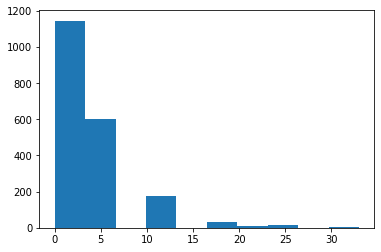

In [192]:
plt.hist(bzlf1_image[cyto_binary == True])

In [193]:
bzlf1_cyto

[1985, 7336, 5.375671177215844, 3.6957178841309823, 33, 0, 0.0]

In [174]:
import random
random_selection = np.random.randint(0, len(matches), 9)


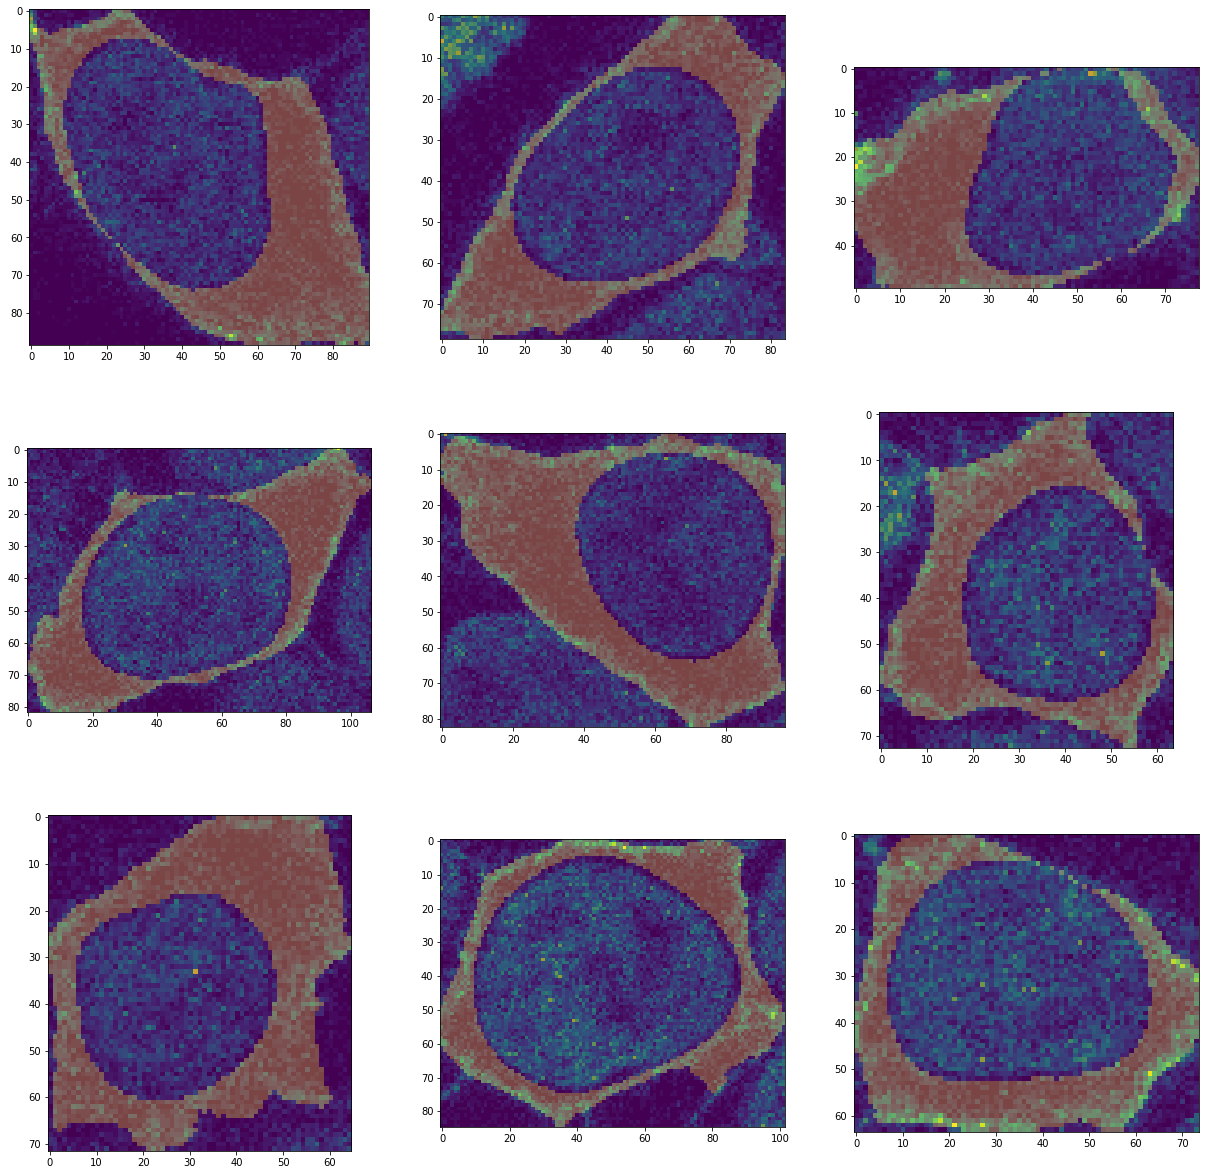

In [179]:
fig = plt.figure(figsize=(21,21))
for i in range(9):
    match = matches[random_selection[i]]
    ## for nuclei and total cells we can use slices from regionprops
    # get nuclei properties

    nucl_slice = stardist_objects[match[0]].slice
    nucl_binary = stardist_objects[match[0]].filled_image
    nucl_label = stardist_objects[match[0]].label

    # get cell properties
    cell_slice = cell_objects[match[1]].slice
    cell_binary = cell_objects[match[1]].filled_image
    cell_label = cell_objects[match[1]].label

    ## use total images not slices next
    ## membranes may lay slightly outside of slices
    ## binary xor not possible from slices of different sizes

    # get cytoplasm properties
    cyto_binary = np.logical_xor(binary_dilation(cell_label_image == cell_label),(stardist_label_image == nucl_label))

    # get membrane properties
    membrane_binary = binary_dilation(find_boundaries(cell_label_image == cell_label, mode='thick'))
    ax = fig.add_subplot('33'+str(i))
    # ax.imshow(membrane_image[cell_slice])
    # ax.imshow(membrane_binary[cell_slice], alpha = 0.3)
    ax.imshow(np.add(membrane_image[cell_slice], nuclei_image[cell_slice]))
    # ax.imshow(stardist_label_image[cell_slice], alpha = 0.4, vmax=1)
    ax.imshow(cyto_binary[cell_slice], alpha = 0.3)

In [169]:
np.add(membrane_image[cell_slice], nuclei_image[cell_slice])

array([[ 7, 20,  7, ...,  1,  1,  1],
       [14, 20, 30, ...,  1,  1,  1],
       [ 7,  7, 20, ...,  7,  1,  1],
       ...,
       [ 1,  1, 20, ..., 19, 28, 43],
       [14,  1, 20, ..., 23, 28, 26],
       [ 1,  7,  7, ..., 39, 25, 18]], dtype=uint8)

In [118]:
from matplotlib.patches import Polygon as Poly
from matplotlib.collections import PatchCollection

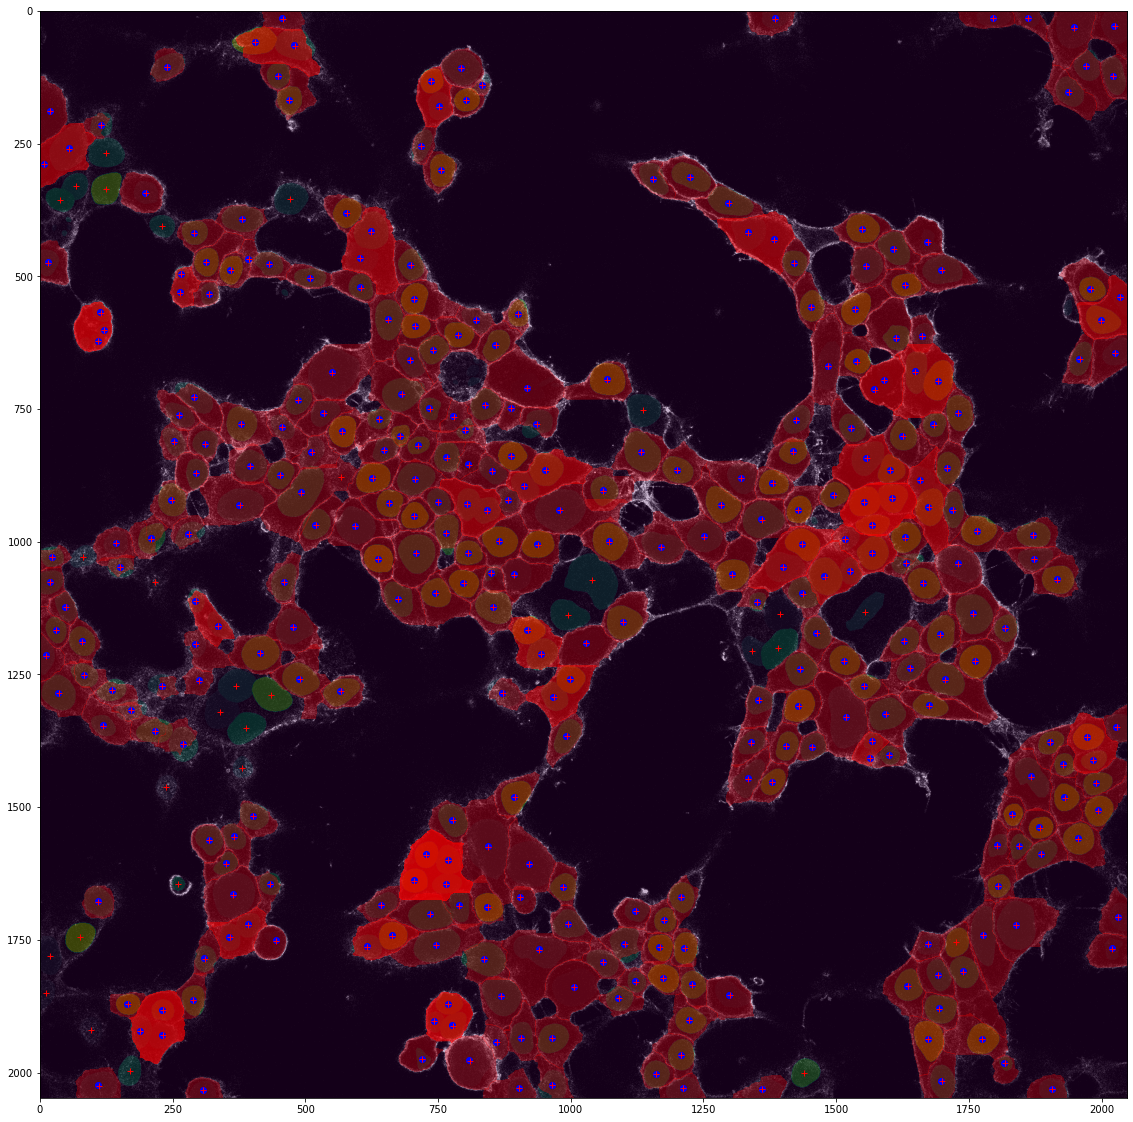

In [119]:
# check output
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.imshow(membrane_image, cmap='gray', vmin=0, vmax=80)
ax.imshow(stardist_label_image, alpha=0.3)
mem_outlines = []
for match in matches:
    mem_poly = np.flip(cell_objects[match[1]].coords,axis=1)
    poly = Poly(mem_poly)
    nucl_point = stardist_objects[match[0]].centroid
    mem_outlines.append(poly)
    ax.plot(int(nucl_point[1]), int(nucl_point[0]), 'ob')
pc = PatchCollection(mem_outlines, fc=(1,0,0,0), ec=(1,0,0,0.3))
ax.add_collection(pc)
for nucl_item in stardist_objects:
    ax.plot(nucl_item.centroid[1], nucl_item.centroid[0], '+r')


(array([10689., 22086., 29581., 31987., 25796., 17751.,  9046.,  2986.,
          558.,   110.]),
 array([5.59944322e-01, 2.83977247e+02, 5.67394550e+02, 8.50811852e+02,
        1.13422915e+03, 1.41764646e+03, 1.70106376e+03, 1.98448106e+03,
        2.26789837e+03, 2.55131567e+03, 2.83473297e+03]),
 <a list of 10 Patch objects>)

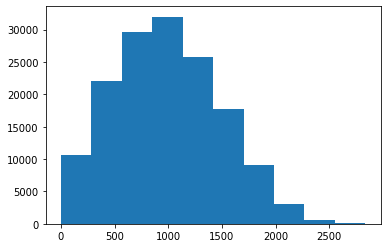

In [70]:
plt.hist(dmap.ravel())

In [89]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, Polygon

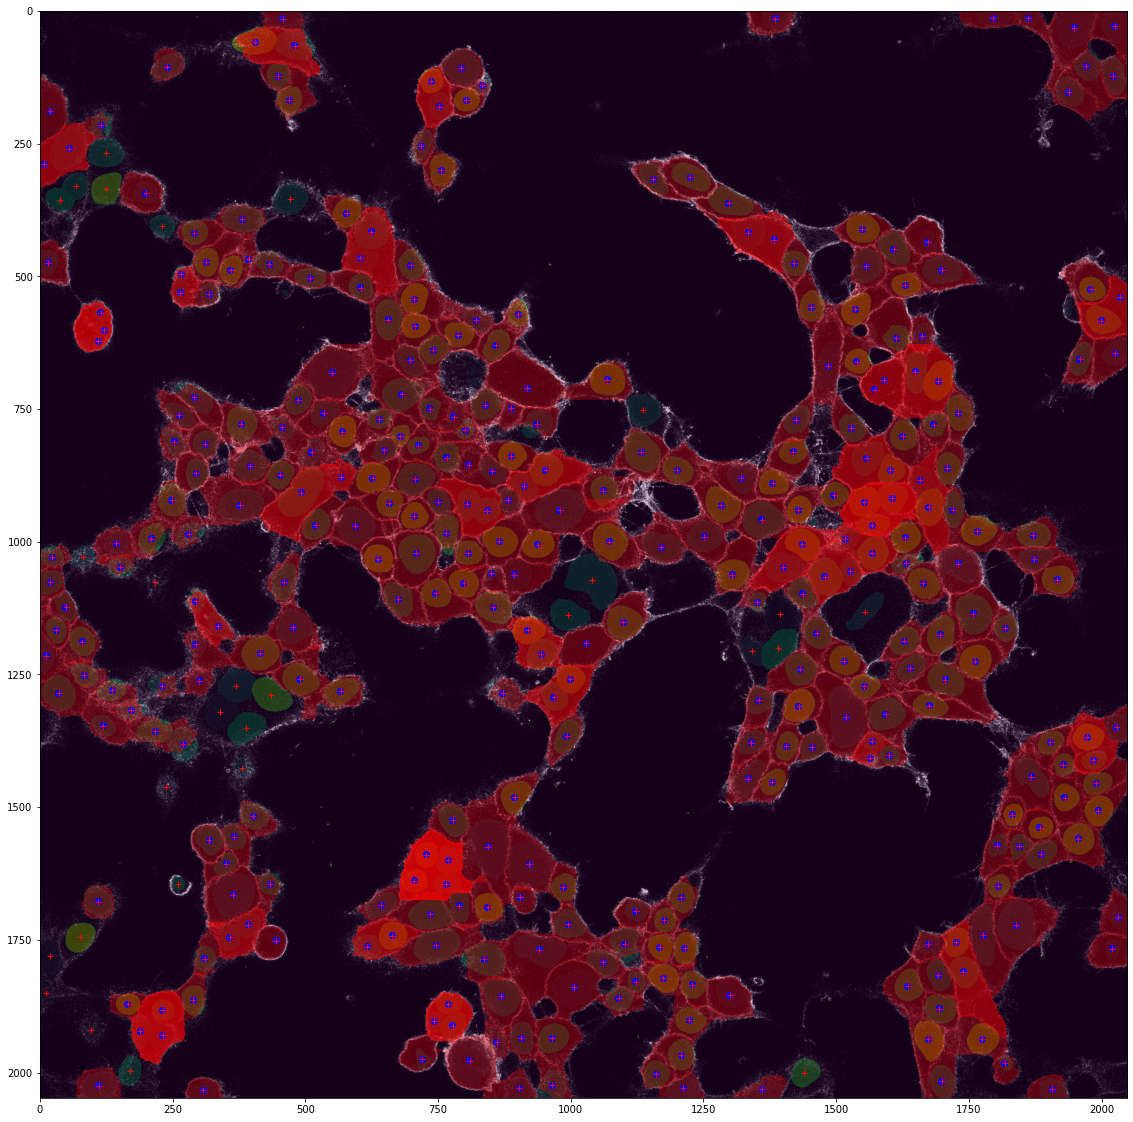

In [90]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.imshow(membranes, cmap='gray', vmin=0, vmax=80)
ax.imshow(segmented_nuclei, alpha=0.3)
mem_outlines = []
for match in match_nuclei_membrane:
    mem_box = props_membranes[match[0]].bbox
    mem_poly = np.flip(props_membranes[match[0]].coords,axis=1)
    rect = Rectangle((mem_box[1], mem_box[0]), mem_box[3]-mem_box[1], mem_box[2]-mem_box[0])
    poly = Polygon(mem_poly)
    nucl_point = props_nuclei[match[1]].centroid
    mem_outlines.append(poly)
    # print((int(nucl_point[1]), int(nucl_point[0])))
    ax.plot(int(nucl_point[1]), int(nucl_point[0]), 'ob')
pc = PatchCollection(mem_outlines, fc=(1,0,0,0), ec=(1,0,0,0.3))
ax.add_collection(pc)
for nucl_item in props_nuclei:
    ax.plot(nucl_item.centroid[1], nucl_item.centroid[0], '+r')

In [22]:
# plot matches in same color
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.imshow(membranes, cmap='gray', vmin=0, vmax=80)
ax.imshow(segmented_nuclei, alpha=0.3)
mem_outlines = []
for match in match_nuclei_membrane:
    mem_box = props_membranes[match[0]].bbox
    mem_poly = np.flip(props_membranes[match[0]].coords,axis=1)
    rect = Rectangle((mem_box[1], mem_box[0]), mem_box[3]-mem_box[1], mem_box[2]-mem_box[0])
    poly = Polygon(mem_poly)
    nucl_point = props_nuclei[match[1]].centroid
    mem_outlines.append(poly)
    # print((int(nucl_point[1]), int(nucl_point[0])))
    ax.plot(int(nucl_point[1]), int(nucl_point[0]), 'ob')
pc = PatchCollection(mem_outlines, fc=(1,0,0,0), ec=(1,0,0,0.3))
ax.add_collection(pc)
for nucl_item in props_nuclei:
    ax.plot(nucl_item.centroid[1], nucl_item.centroid[0], '+r')

array([[685, 799],
       [685, 800],
       [685, 801],
       [685, 802],
       [686, 798],
       [686, 799],
       [686, 800],
       [686, 801],
       [686, 802],
       [687, 797],
       [687, 798],
       [687, 799],
       [687, 800],
       [687, 801],
       [687, 802],
       [687, 803],
       [688, 796],
       [688, 797],
       [688, 798],
       [688, 799],
       [688, 800],
       [688, 801],
       [688, 802],
       [688, 803],
       [688, 804],
       [689, 795],
       [689, 796],
       [689, 797],
       [689, 798],
       [689, 799],
       [689, 800],
       [689, 801],
       [689, 802],
       [689, 803],
       [689, 804],
       [690, 794],
       [690, 795],
       [690, 796],
       [690, 797],
       [690, 798],
       [690, 799],
       [690, 800],
       [690, 801],
       [690, 802],
       [690, 803],
       [690, 804],
       [691, 794],
       [691, 795],
       [691, 796],
       [691, 797],
       [691, 798],
       [691, 799],
       [691,

In [91]:
control_images = glob('/nas_storage/andreas.ettinger/project_agv/control_images/race_segmentation/*.png')

In [92]:
import random

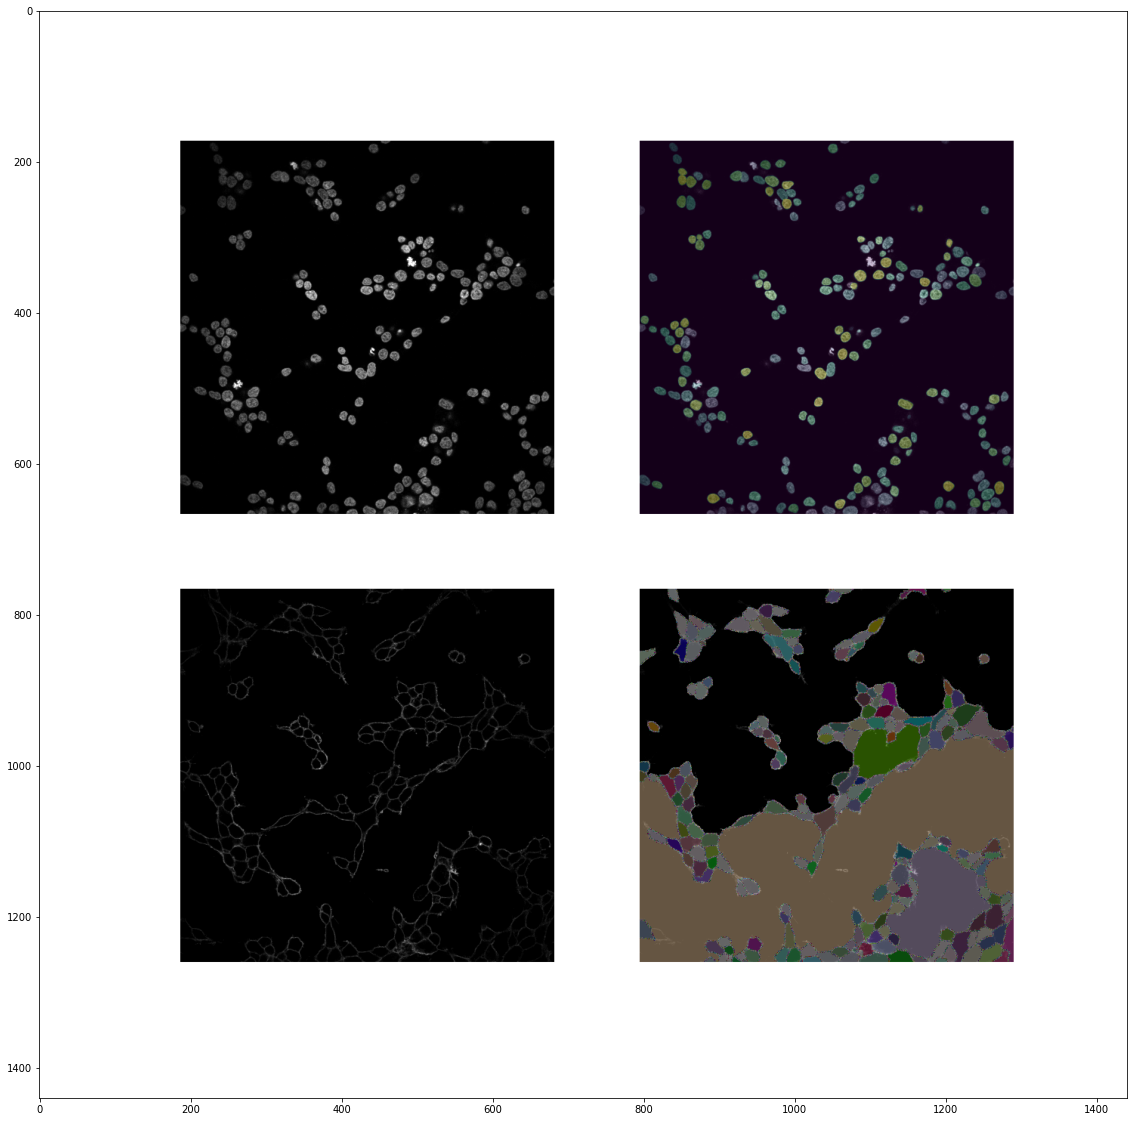

In [112]:
cont_img = imread(control_images[random.randint(0,len(control_images))])
plt.figure(figsize = (20,20))
plt.imshow(cont_img)

In [231]:
for match in match_nuclei_membrane:
    ## for nuclei and total cells we can use slices from regionprops
    # get nuclei properties
    nucl_slice = props_nuclei[match[1]].slice
    nucl_binary = props_nuclei[match[1]].filled_image
    nucl_label = props_nuclei[match[1]].label
    
    # get cell properties
    cell_slice = props_membranes[match[0]].slice
    cell_binary = props_membranes[match[0]].filled_image
    cell_label = props_membranes[match[0]].label
    
    ## use total images not slices next
    ## membranes may lay slightly outside of slices
    ## binary xor not possible from slices of different sizes
    
    # get cytoplasm properties
    cyto_binary = np.logical_xor((segmented_membranes == mem_label),(segmented_nuclei == nucl_label))
    
    # get membrane properties
    membrane_binary = binary_dilation(find_boundaries(segmented_membranes == mem_label, mode='thick'))

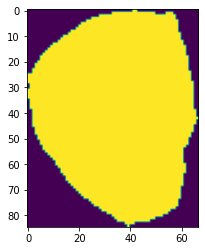

In [235]:
plt.imshow(cell_binary)

In [158]:
gp350_selected = gp350[mem_slice]
np.mean(gp350_selected[mem_binary==True])

0.7454895357228771

In [166]:
get_measurements(nucl_binary, gp350[nucl_slice])

[2394, 1471, 2.0340809600897822, 0.614452798663325, 20, 0, 0.0]

In [167]:
get_measurements(mem_binary, gp350[mem_slice])

[4157, 3099, 2.2362684953842984, 0.7454895357228771, 20, 0, 0.0]

In [ ]:
get_measurements(mem_binary, gp350[mem_slice])

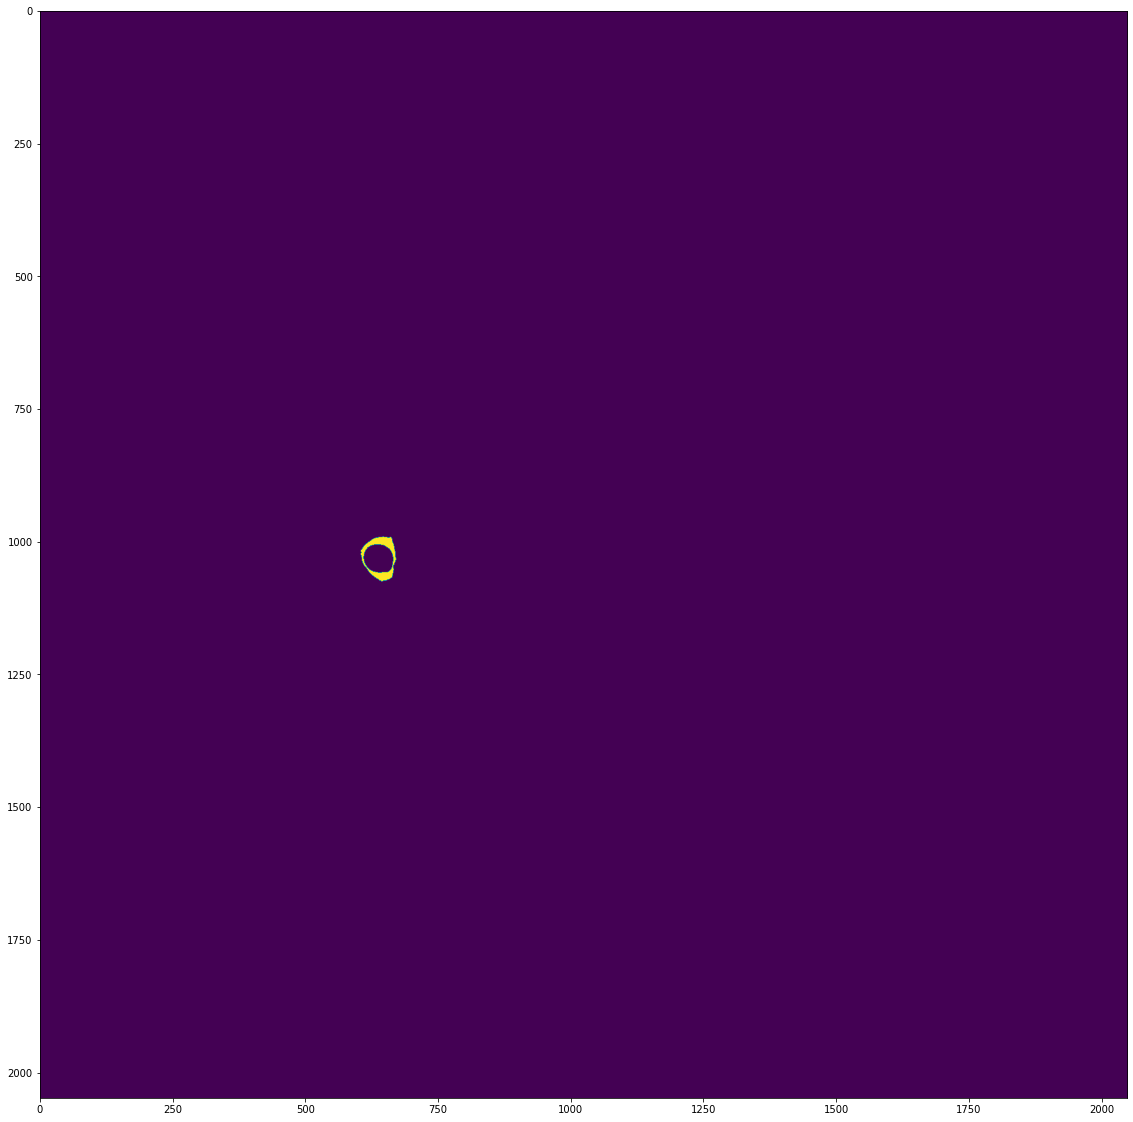

In [202]:
plt.figure(figsize=(20,20))
plt.imshow(np.logical_xor((segmented_membranes == mem_label),(segmented_nuclei == nucl_label)))

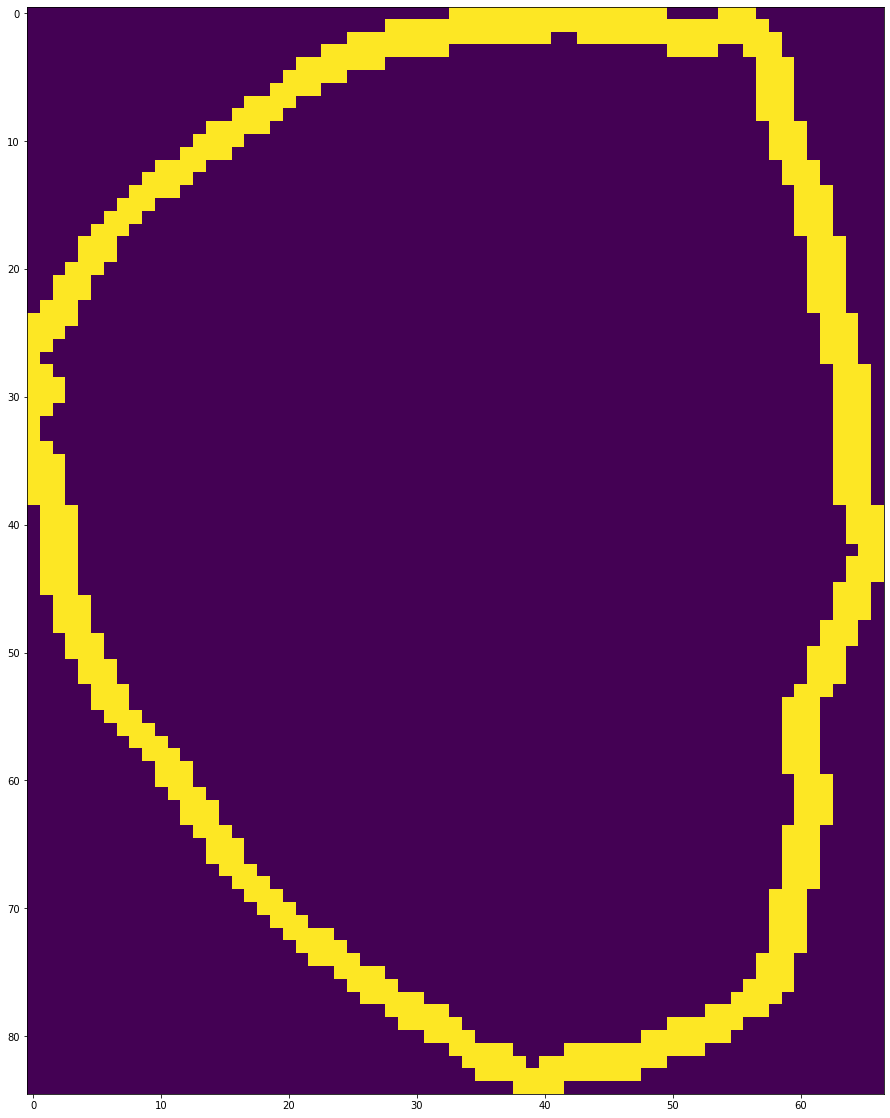

In [216]:
plt.figure(figsize=(20,20))
plt.imshow(binary_dilation(find_boundaries(mem_binary, mode='inner')))

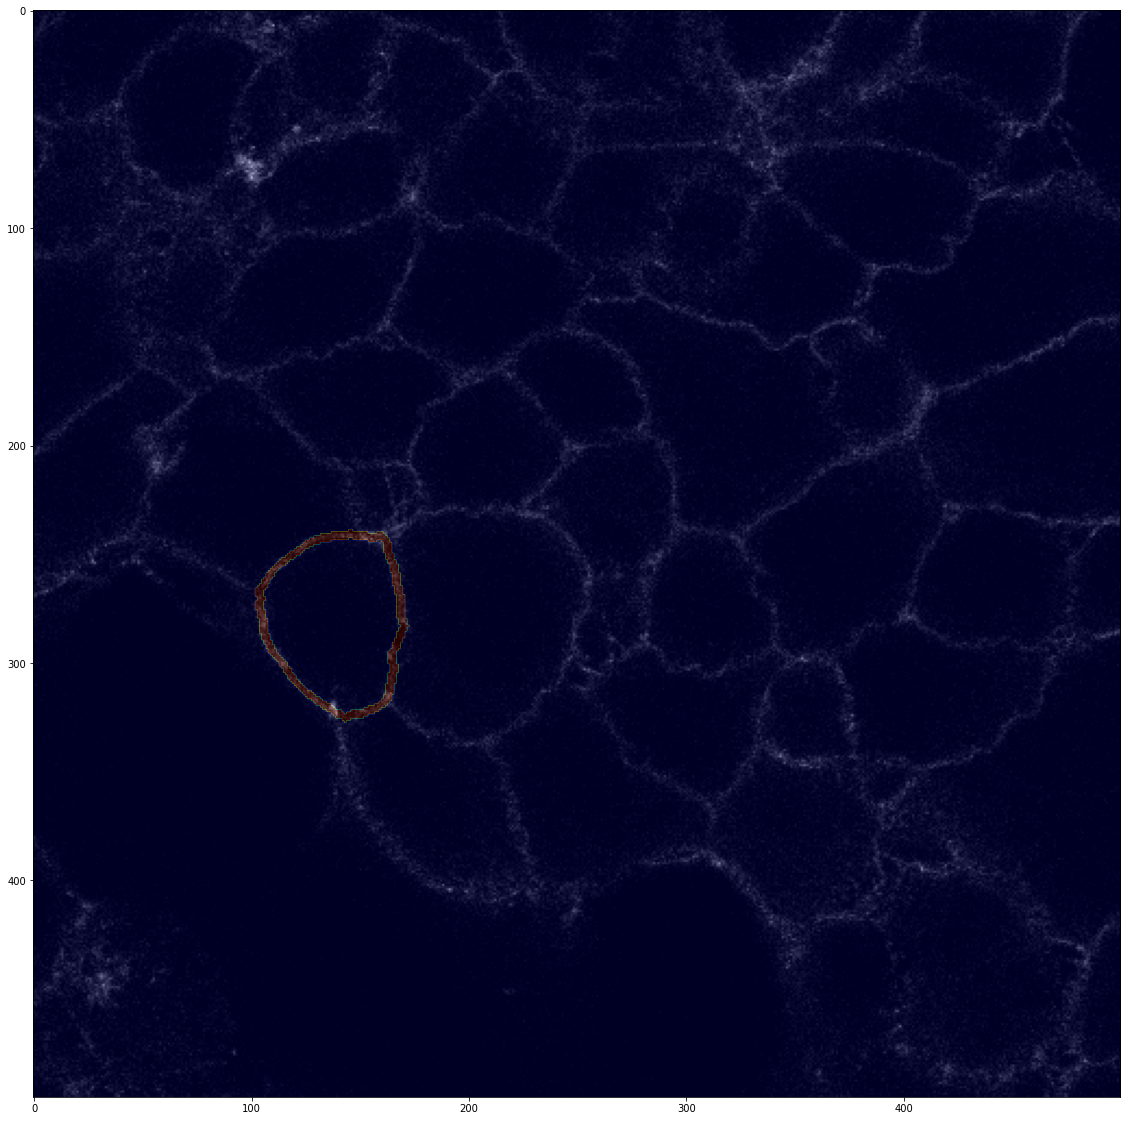

In [230]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.imshow(membranes[750:1250,500:1000], cmap='gray')
ax.imshow(binary_dilation(find_boundaries(segmented_membranes == mem_label, mode='thick'))[750:1250,500:1000], cmap='jet', alpha=0.3)